<a href="https://colab.research.google.com/github/Njarrin/ToxicityTestingCapstonenelsonjarrin/blob/main/Comparison_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Nelson Jarrin
**ML Libraries**: pandas, NumPy, Matplotlib, scikit-learn

**Notebook Purpose**: Compares the performance of a fine-tuned LLM (created in the LLM Notebook) with the Google Perspective API.

**Notebook Inspiration Acknowledgement**:
This notebook uses standard data analysis and visualization techniques. The confusion matrix calculation uses the scikit-learn library.

In [ ]:
!pip install pandas matplotlib numpy
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

In [ ]:
# 1. Load LLM Predictions
try:
    llm_df = pd.read_csv("llm_predictions.csv")
    print("LLM predictions loaded successfully!")
except FileNotFoundError:
    print("LLM predictions CSV not found. Run the LLM notebook first.")
    exit()

LLM predictions loaded successfully!


In [ ]:
# 2. Load Perspective API Predictions
try:
    perspective_df = pd.read_csv("perspective_predictions.csv")
    print("Perspective API predictions loaded successfully!")
except FileNotFoundError:
    print("Perspective API predictions CSV not found. Run the Perspective API notebook first.")
    exit()

Perspective API predictions loaded successfully!


In [ ]:
# 3. Merge DataFrames
comparison_df = pd.merge(perspective_df, llm_df, on="comment", how="inner")
print(comparison_df.head())

                                             comment  perspective_toxicity  \
0  When you have Conservative members now feeling...              0.035456   
1  That's one of the problem, as Germany sent out...              0.110002   
2  Yesshe is, and if she was always and only refe...              0.036634   
3  There is nothing honourable about Stephen Harper.              0.178050   
4  What a pathetic piece of writing. I have no re...              0.751094   

   predicted_class  toxicity_prob  
0                0       0.117826  
1                0       0.142107  
2                0       0.117643  
3                0       0.136507  
4                0       0.198661  


In [ ]:
# 4. Thresholds
threshold_llm = 0.12  #Chosen based on guidance
threshold_perspective = 0.5  # Common threshold

In [ ]:
# 5. Create Binary Classifications
comparison_df['llm_toxic'] = (comparison_df['toxicity_prob'] > threshold_llm).astype(int)
comparison_df['perspective_toxic'] = (comparison_df['perspective_toxicity'] > threshold_perspective).astype(int)

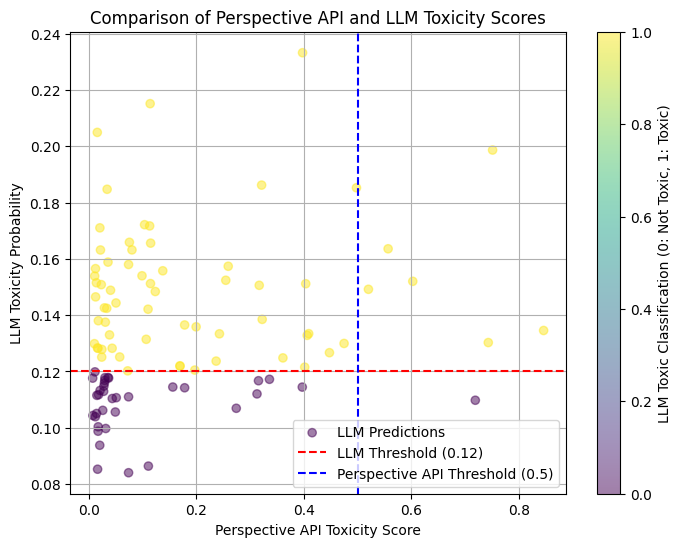

In [ ]:
# 6. Compare and Analyze

plt.figure(figsize=(8, 6))
plt.scatter(comparison_df['perspective_toxicity'], comparison_df['toxicity_prob'], c=comparison_df['llm_toxic'], cmap='viridis', alpha=0.5, label = 'LLM Predictions')
plt.colorbar(label='LLM Toxic Classification (0: Not Toxic, 1: Toxic)')
plt.axhline(y=threshold_llm, color='r', linestyle='--', label=f'LLM Threshold ({threshold_llm})')
plt.axvline(x=threshold_perspective, color='b', linestyle='--', label=f'Perspective API Threshold ({threshold_perspective})')
plt.xlabel("Perspective API Toxicity Score")
plt.ylabel("LLM Toxicity Probability")
plt.title("Comparison of Perspective API and LLM Toxicity Scores")
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
# Calculate Correlation
correlation = np.corrcoef(comparison_df['perspective_toxicity'], comparison_df['toxicity_prob'])[0, 1]
print(f"Correlation: {correlation}")

# Compare the number of comments classified as toxic
print("LLM toxic counts:\n",comparison_df['llm_toxic'].value_counts())
print("Perspective API toxic counts:\n",comparison_df['perspective_toxic'].value_counts())

# Calculate agreement
agreement = (comparison_df['llm_toxic'] == comparison_df['perspective_toxic']).sum()
total_comments = len(comparison_df)
agreement_percentage = (agreement / total_comments) * 100
print(f"Agreement between LLM and Perspective API: {agreement_percentage:.2f}%")

#Examine disagreements
disagreements = comparison_df[comparison_df['llm_toxic'] != comparison_df['perspective_toxic']]
print("Disagreements:\n", disagreements)

cm = confusion_matrix(comparison_df['perspective_toxic'], comparison_df['llm_toxic'])
print("Confusion Matrix:\n", cm)

Correlation: 0.20838650945358278
LLM toxic counts:
 llm_toxic
1    65
0    35
Name: count, dtype: int64
Perspective API toxic counts:
 perspective_toxic
0    93
1     7
Name: count, dtype: int64
Agreement between LLM and Perspective API: 40.00%
Disagreements:
                                               comment  perspective_toxicity  \
1   That's one of the problem, as Germany sent out...              0.110002   
3   There is nothing honourable about Stephen Harper.              0.178050   
5   Bernie Sanders is the only one telling the tru...              0.322361   
7             If only Mr Tory wasn't it should read..              0.030506   
8   There are plenty of bands that have demonstrat...              0.016839   
12  Someone with Boogey's level of education can't...              0.242826   
14  I saw Bibi interviewed on CNN yesterday. He is...              0.401485   
15                                       And falling.              0.033806   
16       Just like Unions ex

In [ ]:
# 7. Identify and Prioritize Disagreements

# Create a new DataFrame containing only the disagreements
disagreements = comparison_df[comparison_df['llm_toxic'] != comparison_df['perspective_toxic']].copy()

# Define thresholds
threshold_llm = 0.12
threshold_perspective = 0.5

# Calculate the absolute difference from the thresholds
disagreements['llm_diff'] = abs(disagreements['toxicity_prob'] - threshold_llm)
disagreements['perspective_diff'] = abs(disagreements['perspective_toxicity'] - threshold_perspective)

# Prioritize disagreements near thresholds (you can adjust these ranges)
threshold_range_llm = 0.05  # Consider disagreements within 0.05 of the threshold
threshold_range_perspective = 0.2 # Consider disagreements within 0.2 of the threshold
prioritized_disagreements = disagreements[
    (disagreements['llm_diff'] <= threshold_range_llm) &
    (disagreements['perspective_diff'] <= threshold_range_perspective)
]

# Identify Outliers

# Example 1: LLM very confident, Perspective API not
outliers_llm_high = disagreements[(disagreements['toxicity_prob'] > 0.7) & (disagreements['perspective_toxicity'] < 0.3)]

# Example 2: Perspective API very confident, LLM not
outliers_perspective_high = disagreements[(disagreements['perspective_toxicity'] > 0.7) & (disagreements['toxicity_prob'] < 0.3)]

# Print the prioritized disagreements and outliers
print("Prioritized Disagreements (Near Thresholds):\n", prioritized_disagreements)
print("\nOutliers (LLM High Confidence):\n", outliers_llm_high)
print("\nOutliers (Perspective API High Confidence):\n", outliers_perspective_high)

# Sample from the prioritized disagreements:
num_to_sample = 25
if len(prioritized_disagreements) > num_to_sample:
    sampled_disagreements = prioritized_disagreements.sample(n=num_to_sample, random_state=42)
    print(f"\nSampled {num_to_sample} Prioritized Disagreements:\n", sampled_disagreements)
else:
    print("\nNot enough prioritized disagreements to sample. Showing all prioritized disagreements.")
    sampled_disagreements = prioritized_disagreements

Prioritized Disagreements (Near Thresholds):
                                               comment  perspective_toxicity  \
5   Bernie Sanders is the only one telling the tru...              0.322361   
14  I saw Bibi interviewed on CNN yesterday. He is...              0.401485   
20  That is a supposition as opposed to the certai...              0.447532   
26  'So was everybody else'You almost got that one...              0.316865   
28  Let's call it like it is: Harper is pandering ...              0.474732   
45  This column serves as an unintended backhand t...              0.406141   
58  The Liberals have failed Canadians utterly on ...              0.408913   
73  History has taught us that anyone who compares...              0.403369   
93  I agree. Now that I'm older I can't read so we...              0.360951   

    predicted_class  toxicity_prob  llm_toxic  perspective_toxic  llm_diff  \
5                 0       0.138500          1                  0  0.018500   
14     